# Embedding

## Enviroment setup

In [1]:
#@title Setup & Environment Verification

import warnings
warnings.filterwarnings('ignore')

import os
import sys

print("=== ENVIRONMENT CHECK ===")
print(f"Python: {sys.version.split()[0]}")
print(f"JAVA_HOME: {os.environ.get('JAVA_HOME')}")
print(f"SPARK_HOME: {os.environ.get('SPARK_HOME')}")
print(f"Driver Memory: {os.environ.get('SPARK_DRIVER_MEMORY')}")
print(f"Executor Memory: {os.environ.get('SPARK_EXECUTOR_MEMORY')}")
print("=" * 50)

=== ENVIRONMENT CHECK ===
Python: 3.10.12
JAVA_HOME: /usr/lib/jvm/java-8-openjdk-arm64/jre
SPARK_HOME: /opt/spark
Driver Memory: 12g
Executor Memory: 8g


In [33]:
#@title Import Libraries

# PySpark
from pyspark import SparkContext
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, HashingTF, IDF, StringIndexer
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.types import *
from pyspark.sql.window import Window

# SciKit Learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# TensorFlow
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, GlobalMaxPooling1D, Concatenate, SpatialDropout1D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Data manipulation
import pandas as pd
import numpy as np

# Financial data
import yfinance as yf

# Hugging Face
from huggingface_hub import hf_hub_download

# Kaggle
import kagglehub

# Plots
import matplotlib.pyplot as plt

# Utilities
from datetime import datetime, timedelta
import json
import requests
import logging
from tqdm import tqdm
import time
import subprocess
from pathlib import Path
from collections import Counter
import pickle

In [3]:
#@title Start Spark session

print("=== PRE-FLIGHT CHECK ===")

# Verify Java is available
try:
    java_version = subprocess.check_output(['java', '-version'], stderr=subprocess.STDOUT)
    print("Java: ✅ Available")
except Exception as e:
    print(f"Java: ❌ Not available - {e}")

print("=" * 50)

# 🔥 STOP any existing Spark sessions first
try:
    SparkContext.getOrCreate().stop()
    print("🧹 Cleaned up existing Spark session")
except:
    print("🆕 No existing session to clean")

print("=" * 50)

# Create fresh Spark session
spark = SparkSession.builder \
    .appName("Yelp_Sentiment_Analysis") \
    .master("local[*]") \
    .config("spark.driver.memory", "12g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.maxResultSize", "4g") \
    .config("spark.memory.fraction", "0.8") \
    .config("spark.memory.storageFraction", "0.3") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.default.parallelism", "16") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.kryoserializer.buffer.max", "512m") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")

print("✅ Spark session configured with:")
print(f"   - Driver Memory: 12GB")
print(f"   - Executor Memory: 8GB")
print(f"   - Max Result Size: 4GB")
print(f"   - Parallelism: 16 cores")
print(f"   - Shuffle Partitions: 200")

=== PRE-FLIGHT CHECK ===
Java: ✅ Available


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/07 00:19:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


🧹 Cleaned up existing Spark session
✅ Spark session configured with:
   - Driver Memory: 12GB
   - Executor Memory: 8GB
   - Max Result Size: 4GB
   - Parallelism: 16 cores
   - Shuffle Partitions: 200


## LSTM for Sentiment Analysis

### Data Preparation

In [4]:
#@title Load dataset

# Parquet path
parquet_path = "../data/clean/yelp_reviews_tokenized.parquet"

yelp_df = spark.read.parquet(parquet_path)

# Show schema to understand structure
print("📋 Schema of Yelp Reviews:")
yelp_df.printSchema()

# Sample
print("\n📋 Sample:")
yelp_df.show(5, truncate=80)

📋 Schema of Yelp Reviews:
root
 |-- text: string (nullable = true)
 |-- sentiment: string (nullable = true)
 |-- text_length: integer (nullable = true)
 |-- word_count: integer (nullable = true)
 |-- text_clean: string (nullable = true)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens_filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)


📋 Sample:
+--------------------------------------------------------------------------------+---------+-----------+----------+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+
|                                                                            text|sentiment|text_length|word_count|                                                                      text_clean|                 

In [6]:
#@ Split data into train, valdation and test

# Split: 70% train, 15% validation, 15% test
train_df, temp_df = yelp_df.randomSplit([0.7, 0.3], seed=42)
val_df, test_df = temp_df.randomSplit([0.5, 0.5], seed=42)

print("📊 Train: ", train_df.count())
print("📊 Validation: ", val_df.count())
print("📊 Test: ", test_df.count())

📊 Train:  291152


📊 Validation:  62355


📊 Test:  61924


In [9]:
#@title Convert Spark dataframes to Pandas

print("\n⏳ Converting Spark DataFrames to Pandas...")

train_pd = train_df.toPandas()
val_pd = val_df.toPandas()
test_pd = test_df.toPandas()

print(f"Train: {len(train_pd):,} samples")
print(f"Val: {len(val_pd):,} samples")
print(f"Test: {len(test_pd):,} samples")

display(train_pd.head())


⏳ Converting Spark DataFrames to Pandas...


Train: 291,152 samples
Val: 62,355 samples
Test: 61,924 samples


,text,sentiment,text_length,word_count,text_clean,tokens,tokens_filtered
0,!! HORRIBLE - CROOKS - NO EXPERIENCE WITH DENT...,negative,1138,187,horrible crooks no experience with dentures...,"[, horrible, , crooks, , no, experience, with,...","[, horrible, , crooks, , experience, dentures,..."
1,"!!!!!!!! Walked up to the bar, stepped up an...",negative,518,100,walked up to the bar stepped up and asked f...,"[, , , walked, up, to, the, bar, stepped, up, ...","[, , , walked, bar, stepped, asked, two, coron..."
2,"!!!DO NOT BUY HERE!!!\n\nI too, was taken adva...",negative,825,152,do not buy here\n\ni too was taken advantage o...,"[do, not, buy, here, , i, too, was, taken, adv...","[buy, , taken, advantage, scam, shopping, arou..."
3,!!STAY AS FAR AWAY AS YOU CAN FROM THEM!!\n\nO...,negative,774,155,stay as far away as you can from them\n\nonly ...,"[stay, as, far, away, as, you, can, from, them...","[stay, far, away, , reason, gave, one, star, g..."
4,"""0 stars if it was an option!"" My review is re...",negative,4122,733,0 stars if it was an option my review is regar...,"[0, stars, if, it, was, an, option, my, review...","[0, stars, option, review, regarding, office, ..."


In [15]:
#@title Extract text and labels

print("\n📋 Extracting tokens and labels...")

train_tokens = train_pd['tokens_filtered'].fillna('').tolist()
val_tokens = val_pd['tokens_filtered'].fillna('').tolist()
test_tokens = test_pd['tokens_filtered'].fillna('').tolist()

train_labels = train_pd['sentiment'].tolist()
val_labels = val_pd['sentiment'].tolist()
test_labels = test_pd['sentiment'].tolist()

print(f"Train samples: {len(train_tokens):,}")
print(f"Val samples: {len(val_tokens):,}")
print(f"Test samples: {len(test_tokens):,}")
print(f"\n🔍 Example tokens: {train_tokens[0][:10]}")


📋 Extracting tokens and labels...
Train samples: 291,152
Val samples: 62,355
Test samples: 61,924

🔍 Example tokens: ['' 'horrible' '' 'crooks' '' 'experience' 'dentures' 'sold' 'bag' 'goods']


In [16]:
#@title Encode labels

print("\n🏷️ Encoding labels...")

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)
test_labels_encoded = label_encoder.transform(test_labels)

print(f"Classes: {label_encoder.classes_}")
print(f"Label distribution (train): {np.bincount(train_labels_encoded)}")


🏷️ Encoding labels...
Classes: ['negative' 'neutral' 'positive']
Label distribution (train): [97178 97020 96954]


In [19]:
#@title Build vocabulary from training tokens

print("\n📚 Building vocabulary from tokens...")

MAX_VOCAB_SIZE = 20000
MAX_SEQUENCE_LENGTH = 200

# Count all words in training set
all_words = []
for tokens in train_tokens:
    all_words.extend(tokens)

word_counts = Counter(all_words)
print(f"Total unique words in training: {len(word_counts):,}")

# Keep only top MAX_VOCAB_SIZE words
most_common = word_counts.most_common(MAX_VOCAB_SIZE - 2)  # -2 for <PAD> and <OOV>

# Create word-to-index mapping
word_to_index = {'<PAD>': 0, '<OOV>': 1}  # Reserve 0 for padding, 1 for unknown
for idx, (word, count) in enumerate(most_common, start=2):
    word_to_index[word] = idx

print(f"Vocabulary size (including <PAD> and <OOV>): {len(word_to_index):,}")
print(f"Using top {MAX_VOCAB_SIZE:,} words")


📚 Building vocabulary from tokens...
Total unique words in training: 210,956
Vocabulary size (including <PAD> and <OOV>): 20,000
Using top 20,000 words


In [20]:
#@title Converting tokens to numerical sequences

print("\n🔢 Converting tokens to numerical sequences...")

def tokens_to_sequences(tokens_list, word_to_index):
    sequences = []
    for tokens in tokens_list:
        sequence = [word_to_index.get(token, 1) for token in tokens]  # 1 = <OOV>
        sequences.append(sequence)
    return sequences

train_sequences = tokens_to_sequences(train_tokens, word_to_index)
val_sequences = tokens_to_sequences(val_tokens, word_to_index)
test_sequences = tokens_to_sequences(test_tokens, word_to_index)

print(f"Example transformation:")
print(f"Tokens: {train_tokens[0][:10]}")
print(f"Sequence: {train_sequences[0][:10]}")


🔢 Converting tokens to numerical sequences...
Example transformation:
Tokens: ['' 'horrible' '' 'crooks' '' 'experience' 'dentures' 'sold' 'bag' 'goods']
Sequence: [2, 355, 2, 7254, 2, 41, 14235, 1230, 803, 2029]


In [ ]:
#@title Pad sequences

print("\n📏 Padding sequences to same length...")

train_padded = pad_sequences(
    train_sequences,
    maxlen=MAX_SEQUENCE_LENGTH,
    padding='post',
    truncating='post',
    value=0
)

val_padded = pad_sequences(
    val_sequences,
    maxlen=MAX_SEQUENCE_LENGTH,
    padding='post',
    truncating='post',
    value=0
)

test_padded = pad_sequences(
    test_sequences,
    maxlen=MAX_SEQUENCE_LENGTH,
    padding='post',
    truncating='post',
    value=0
)

print(f"Train shape: {train_padded.shape}")
print(f"Val shape: {val_padded.shape}")
print(f"Test shape: {test_padded.shape}")


📏 Padding sequences to same length...
Train shape: (291152, 200)
Val shape: (62355, 200)
Test shape: (61924, 200)


In [27]:
#@title Convert to categorical

train_labels_cat = to_categorical(train_labels_encoded, num_classes=3)
val_labels_cat = to_categorical(val_labels_encoded, num_classes=3)
test_labels_cat = to_categorical(test_labels_encoded, num_classes=3)

print(f"\n✅ Data preparation complete!")
print(f"Label shape: {train_labels_cat.shape}")

# Save for later use
print("\n💾 Saving preprocessed data...")
np.save('../data/processed/train_padded.npy', train_padded)
np.save('../data/processed/val_padded.npy', val_padded)
np.save('../data/processed/test_padded.npy', test_padded)
np.save('../data/processed/train_labels_cat.npy', train_labels_cat)
np.save('../data/processed/val_labels_cat.npy', val_labels_cat)
np.save('../data/processed/test_labels_cat.npy', test_labels_cat)

with open('../data/processed/word_to_index.pkl', 'wb') as f:
    pickle.dump(word_to_index, f)
with open('../data/processed/label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

# Store for model building
VOCAB_SIZE = len(word_to_index)

print(f"✅ Saved to ../data/processed/")
print(f"\n📊 Final vocabulary size: {VOCAB_SIZE:,}")


✅ Data preparation complete!
Label shape: (291152, 3)

💾 Saving preprocessed data...
✅ Saved to ../data/processed/

📊 Final vocabulary size: 20,000


### LSTM

In [ ]:
#@title Build LSTM Model with Embeddings

print("=" * 80)
print("🏗️ BUILDING LSTM MODEL")
print("=" * 80)

# Model parameters
VOCAB_SIZE = MAX_VOCAB_SIZE
EMBEDDING_DIM = 128  # Each word → 128-dimensional vector
LSTM_UNITS = 64  # LSTM hidden state size
DROPOUT_RATE = 0.5

print(f"\n📐 Model architecture:")
print(f"   Vocabulary size: {VOCAB_SIZE:,}")
print(f"   Embedding dimension: {EMBEDDING_DIM}")
print(f"   LSTM units: {LSTM_UNITS}")
print(f"   Max sequence length: {MAX_SEQUENCE_LENGTH}")

# Build model
model = Sequential([
    # 1. Embedding Layer (learns word representations)
    Embedding(
        input_dim=VOCAB_SIZE,
        output_dim=EMBEDDING_DIM,
        input_length=MAX_SEQUENCE_LENGTH,
        name='embedding'
    ),
    
    # 2. Bidirectional LSTM (reads forward AND backward)
    Bidirectional(
        LSTM(LSTM_UNITS, return_sequences=False),
        name='bidirectional_lstm'
    ),
    
    # 3. Dropout (regularization)
    Dropout(DROPOUT_RATE, name='dropout'),
    
    # 4. Dense Output Layer (3 classes: neg, neu, pos)
    Dense(3, activation='softmax', name='output')
])

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Show architecture
print("\n🔍 Model Summary:")
model.summary()

# Count parameters
trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_weights])
print(f"\n📊 Total trainable parameters: {trainable_params:,}")

🏗️ BUILDING LSTM MODEL

📐 Model architecture:
   Vocabulary size: 20,000
   Embedding dimension: 128
   LSTM units: 64
   Max sequence length: 200

🔍 Model Summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 128)          2560000   
                                                                 
 bidirectional_lstm (Bidire  (None, 128)               98816     
 ctional)                                                        
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 output (Dense)              (None, 3)                 387       
                                                                 
Total params: 2659203 (10.14 MB)
Trainable params: 2659203 (10.14 MB)
Non-trainable param

In [31]:
#@title Train LSTM Model

print("=" * 80)
print("🎓 TRAINING LSTM MODEL")
print("=" * 80)

# Training parameters
BATCH_SIZE = 32
EPOCHS = 20

# Callbacks
callbacks = [
    # Early stopping: stop if val_loss doesn't improve for 3 epochs
    EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Save best model
    ModelCheckpoint(
        '../models/lstm_sentiment_best.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    
    # Reduce learning rate if stuck
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        verbose=1,
        min_lr=0.00001
    )
]

print(f"\n⚙️ Training parameters:")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Max epochs: {EPOCHS}")
print(f"   Callbacks: Early Stopping, Model Checkpoint, LR Reduction")

print("\n🚀 Starting training...\n")

# Train model
history = model.fit(
    train_padded,
    train_labels_cat,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(val_padded, val_labels_cat),
    callbacks=callbacks,
    verbose=1
)

print("\n✅ Training complete!")

# Save final model
model.save('../models/lstm_sentiment_final.keras')
print("💾 Model saved to ../models/")

# Save history
with open('../models/lstm_training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)
print("💾 Training history saved")

🎓 TRAINING LSTM MODEL

⚙️ Training parameters:
   Batch size: 32
   Max epochs: 20
   Callbacks: Early Stopping, Model Checkpoint, LR Reduction

🚀 Starting training...

Epoch 1/20


2025-11-07 00:44:35.991451: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 232921600 exceeds 10% of free system memory.


9098/9099 [============================>.] - ETA: 0s - loss: 0.5727 - accuracy: 0.7561 - precision: 0.7801 - recall: 0.7199
Epoch 1: val_accuracy improved from -inf to 0.78029, saving model to ../models/lstm_sentiment_best.keras
9099/9099 [==============================] - 632s 69ms/step - loss: 0.5727 - accuracy: 0.7561 - precision: 0.7801 - recall: 0.7199 - val_loss: 0.5158 - val_accuracy: 0.7803 - val_precision: 0.8001 - val_recall: 0.7524 - lr: 0.0010
Epoch 2/20
9098/9099 [============================>.] - ETA: 0s - loss: 0.4733 - accuracy: 0.8034 - precision: 0.8160 - recall: 0.7852
Epoch 2: val_accuracy improved from 0.78029 to 0.78906, saving model to ../models/lstm_sentiment_best.keras
9099/9099 [==============================] - 630s 69ms/step - loss: 0.4733 - accuracy: 0.8034 - precision: 0.8160 - recall: 0.7852 - val_loss: 0.5048 - val_accuracy: 0.7891 - val_precision: 0.7993 - val_recall: 0.7751 - lr: 0.0010
Epoch 3/20
9098/9099 [============================>.] - ETA: 0s - 

📊 TRAINING VISUALIZATION (Loading saved history)

📂 Loading training history...
✅ History loaded!
Available metrics: ['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'lr']
Number of epochs: 5

📈 TRAINING STATISTICS
🏆 Best epoch: 2/5
🏆 Best validation accuracy: 0.7891 (78.91%)
🏆 Best validation loss: 0.5048

📊 Final epoch:
   Train accuracy: 0.8840 (88.40%)
   Val accuracy: 0.7771 (77.71%)

⚠️ Potential overfitting detected (gap: 0.1070)


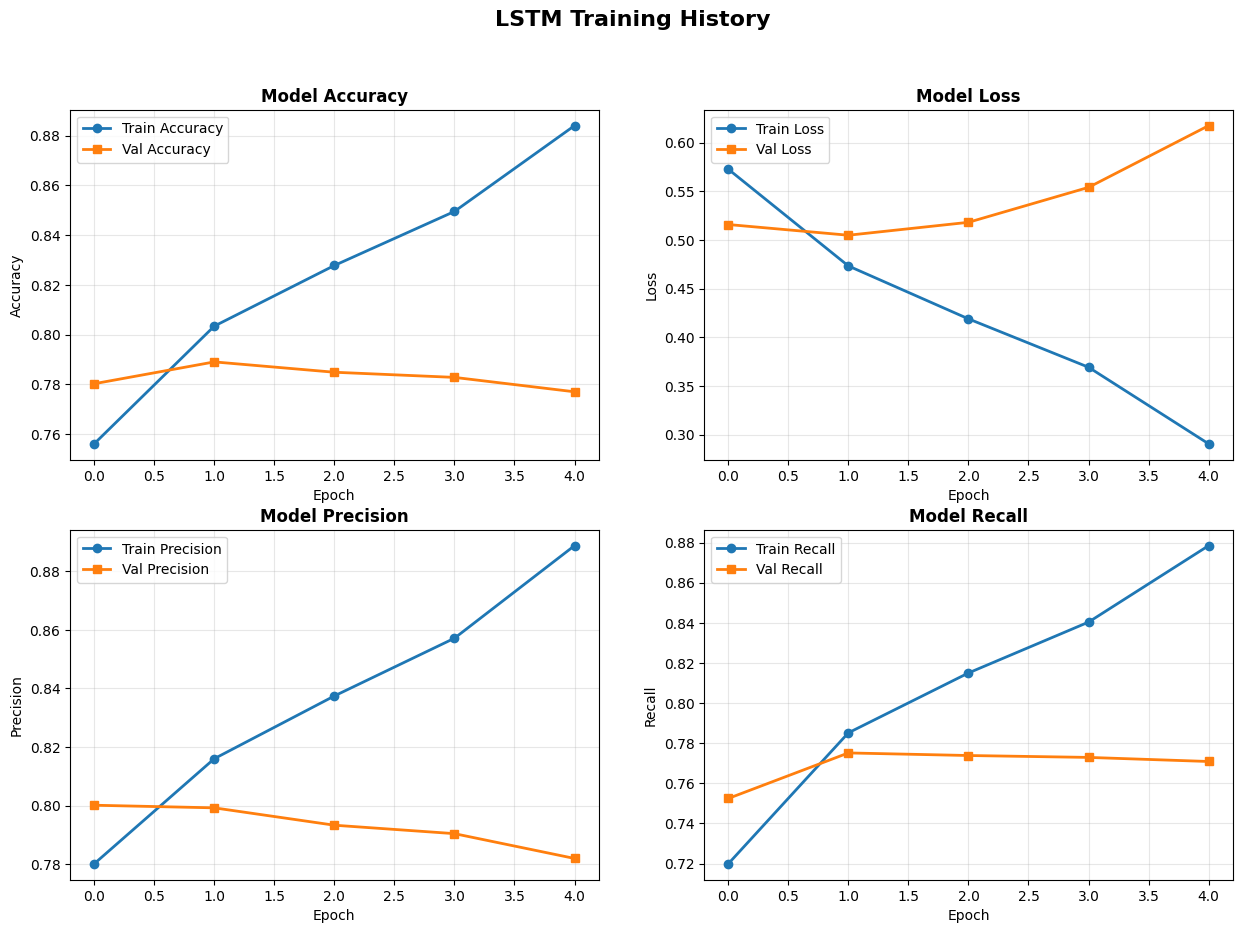

In [35]:
print("=" * 80)
print("📊 TRAINING VISUALIZATION (Loading saved history)")
print("=" * 80)

# Load training history
print("\n📂 Loading training history...")
with open('../models/lstm_training_history.pkl', 'rb') as f:
    history_dict = pickle.load(f)

print(f"✅ History loaded!")
print(f"Available metrics: {list(history_dict.keys())}")
print(f"Number of epochs: {len(history_dict['loss'])}")

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('LSTM Training History', fontsize=16, fontweight='bold')

# 1. Accuracy
axes[0, 0].plot(history_dict['accuracy'], label='Train Accuracy', linewidth=2, marker='o')
axes[0, 0].plot(history_dict['val_accuracy'], label='Val Accuracy', linewidth=2, marker='s')
axes[0, 0].set_title('Model Accuracy', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Loss
axes[0, 1].plot(history_dict['loss'], label='Train Loss', linewidth=2, marker='o')
axes[0, 1].plot(history_dict['val_loss'], label='Val Loss', linewidth=2, marker='s')
axes[0, 1].set_title('Model Loss', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Precision
axes[1, 0].plot(history_dict['precision'], label='Train Precision', linewidth=2, marker='o')
axes[1, 0].plot(history_dict['val_precision'], label='Val Precision', linewidth=2, marker='s')
axes[1, 0].set_title('Model Precision', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Recall
axes[1, 1].plot(history_dict['recall'], label='Train Recall', linewidth=2, marker='o')
axes[1, 1].plot(history_dict['val_recall'], label='Val Recall', linewidth=2, marker='s')
axes[1, 1].set_title('Model Recall', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Print statistics
print("\n" + "=" * 80)
print("📈 TRAINING STATISTICS")
print("=" * 80)

best_epoch = np.argmax(history_dict['val_accuracy']) + 1
best_val_acc = np.max(history_dict['val_accuracy'])
best_val_loss = np.min(history_dict['val_loss'])
final_train_acc = history_dict['accuracy'][-1]
final_val_acc = history_dict['val_accuracy'][-1]

print(f"🏆 Best epoch: {best_epoch}/{len(history_dict['loss'])}")
print(f"🏆 Best validation accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
print(f"🏆 Best validation loss: {best_val_loss:.4f}")
print(f"\n📊 Final epoch:")
print(f"   Train accuracy: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"   Val accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")

# Check for overfitting
overfit_gap = final_train_acc - final_val_acc
if overfit_gap > 0.1:
    print(f"\n⚠️ Potential overfitting detected (gap: {overfit_gap:.4f})")
elif overfit_gap > 0.05:
    print(f"\n⚡ Slight overfitting (gap: {overfit_gap:.4f})")
else:
    print(f"\n✅ Good generalization (gap: {overfit_gap:.4f})")

print("=" * 80)